# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 


# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj




In [10]:
import numpy as np
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
import sys
import openmm as mm
from openmm import app
from openmm import unit
from openmm import *
from openmm.app import *
from openmm.unit import *
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import pandas as pd
from statistics import mean, stdev
from matplotlib import colors
import mdtraj as md
import seaborn as sb


In [12]:
workdir='./'
datadir='c:/Users/hainn/tolu/git/CHEM101.6_S24/data/'
outdir='c:/Users/hainn/tolu/git/CHEM101.6_S24/outdir/'
PDB_file_name = datadir+'butane.pdb'
forcefield_file_name = datadir+'butane.gaff2.xml'

#if not os.path.exists(workDir):
#    os.makedirs(workDir)
    
print(PDB_file_name)
print(forcefield_file_name)

pdb = mm.app.PDBFile(PDB_file_name)
forcefield = mm.app.ForceField(forcefield_file_name)

system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*kelvin, 5.0/picosecond, 2.0*femtoseconds)
integrator.setConstraintTolerance(1e-5)
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

c:/Users/hainn/tolu/git/CHEM101.6_S24/data/butane.pdb
c:/Users/hainn/tolu/git/CHEM101.6_S24/data/butane.gaff2.xml


In [13]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127867 kJ/mol
Potential energy after minimization is 5.295271861905595 kJ/mol


In [14]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 1000, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,44.955176644447874,391.3330879554695
2000,36.157982577289864,312.66575248330616


In [15]:
os.path.join(workdir, "butane_sim.dcd")

'./butane_sim.dcd'

In [18]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.XTCReporter(os.path.join(workdir, "butane_sim.xtc"),100))
                
# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
10250000,20500.000003258898,47.40521926428539,225.73327550854165,--
10500000,21000.00000336076,41.63909705844578,200.74602833528152,2e+04
10750000,21500.000003462625,51.887135854252634,250.83642451558242,2.29e+04
11000000,22000.000003564488,57.32272167889511,343.05721299267816,2.42e+04
11250000,22500.00000366635,31.258331627158984,369.3147146368736,2.47e+04
11500000,23000.000003768215,44.38139018397739,299.9877636399119,2.52e+04
11750000,23500.00000387008,41.91631546243583,211.43758801720097,2.56e+04
12000000,24000.00000397194,48.857504545851704,352.3982420155008,2.6e+04
12250000,24500.000004073805,47.073305611550566,319.83704662432206,2.61e+04
12500000,25000.00000417567,45.33009527045462,251.78726444318383,2.65e+04
12750000,25500.000004277532,49.52772912872504,262.4470543238674,2.68e+04
13000000,26000.000004379395,35.474918616499785,419.5165695928552,2.69e+04
13250000,26500.000004

In [19]:
import mdtraj as md
traj = md.load(os.path.join(workdir, "butane_sim.xtc"), top=PDB_file_name)
traj


<mdtraj.Trajectory with 100000 frames, 14 atoms, 1 residues, without unitcells at 0x174c8d89850>

In [20]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [21]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x174cabd9150>

In [22]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


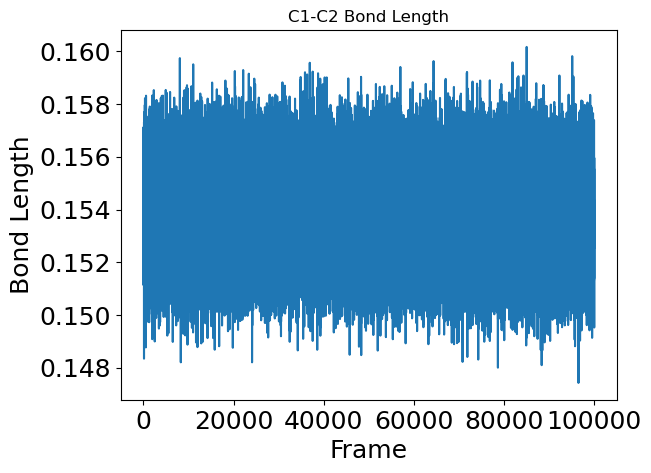

In [23]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C1C2bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

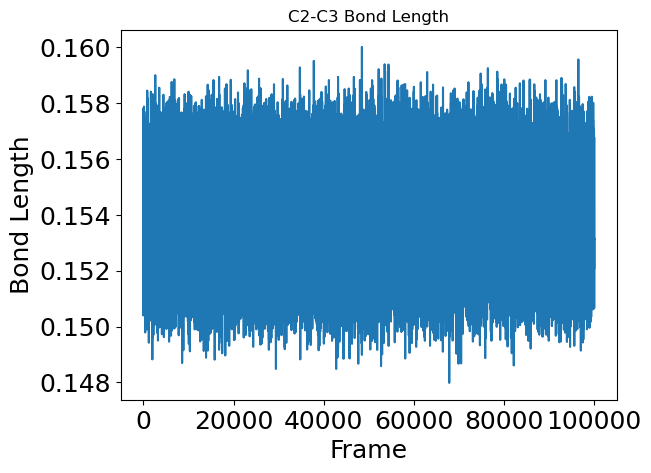

In [24]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C2C3bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

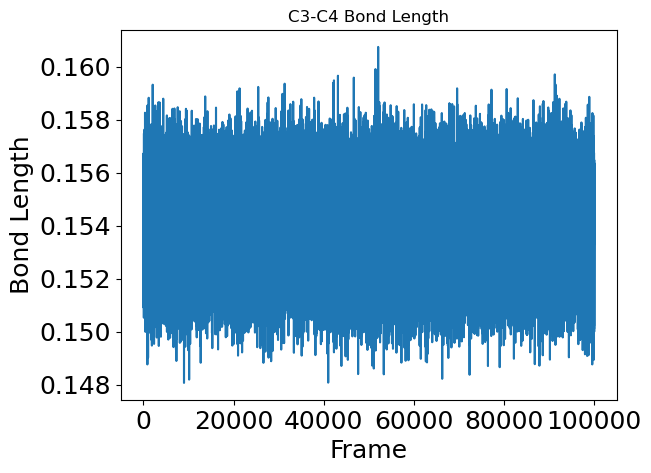

In [25]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C3C4bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

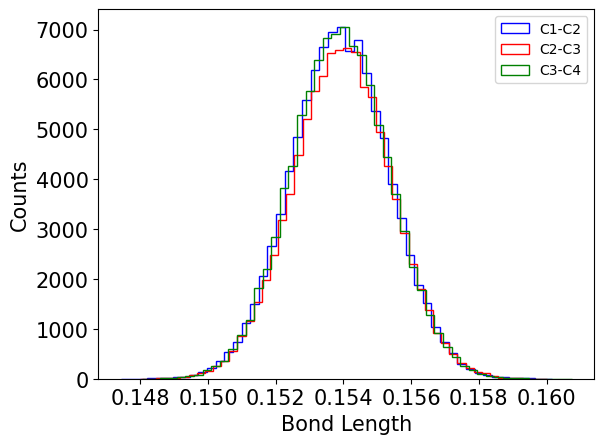

In [26]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

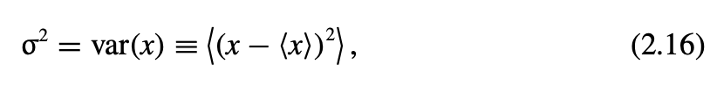

In [27]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [28]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)
print("C1-C2 var:",C1C2var,"C2-C3 var:",C2C3var,"C3-C4 var:",C3C4var)
print("C1-C2 std:",C1C2std,"C2-C3 std:",C2C3std,"C3-C4 std:",C3C4std)

C1-C2 var: 2.0743603e-06 C2-C3 var: 2.0653847e-06 C3-C4 var: 2.045368e-06
C1-C2 std: 0.0014402639625316744 C2-C3 std: 0.001437144636398619 C3-C4 std: 0.0014301636590912765


In [29]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15389945 variance: 2.0743603e-06 std-dev: 0.0014402639
C2-C3 average: 0.1539526 variance: 2.0653847e-06 std-dev: 0.0014371446
C3-C4 average: 0.15390542 variance: 2.045368e-06 std-dev: 0.0014301636


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


Line Parameters: [0.50014848 0.07697595]


C:\Users\hainn\AppData\Local\Temp\ipykernel_8076\1769237437.py:9: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)


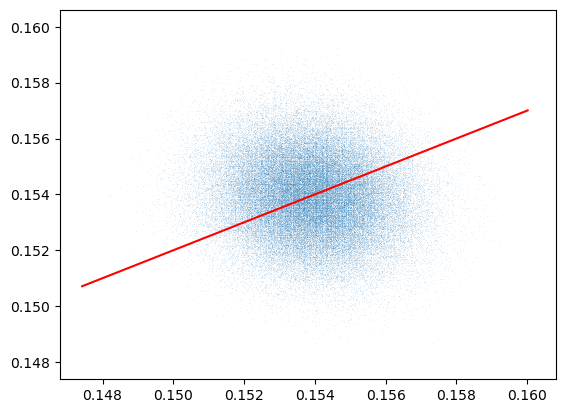

r2: -0.10455460597623094
Line Parameters: [0.49999765 0.07695273]


C:\Users\hainn\AppData\Local\Temp\ipykernel_8076\1769237437.py:22: RankWarning: Polyfit may be poorly conditioned
  line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)


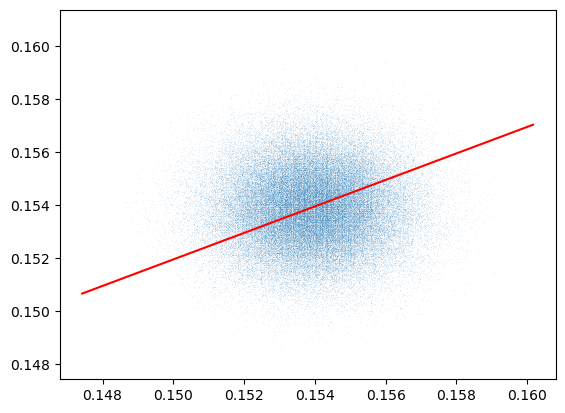

r2: 0.005690879820215422


In [30]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',s=0.1,linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',s=0.1,linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

**Homework Question:  Why does one pair of these bonds appear more correlated than the other?**

***Class Activity*** 

***Lets write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

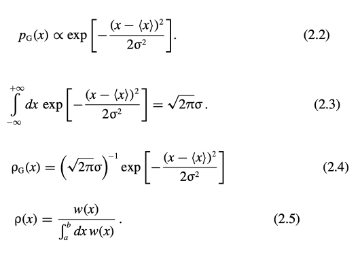
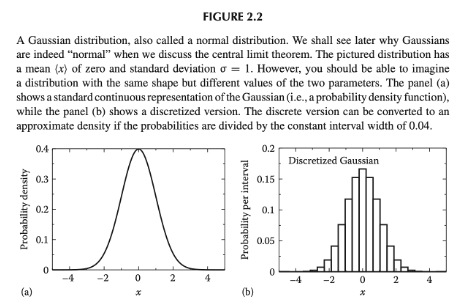

a: 0.17864857462953343 x0: 0.15389898435999452 fit_sigma: 0.0014523329398426032


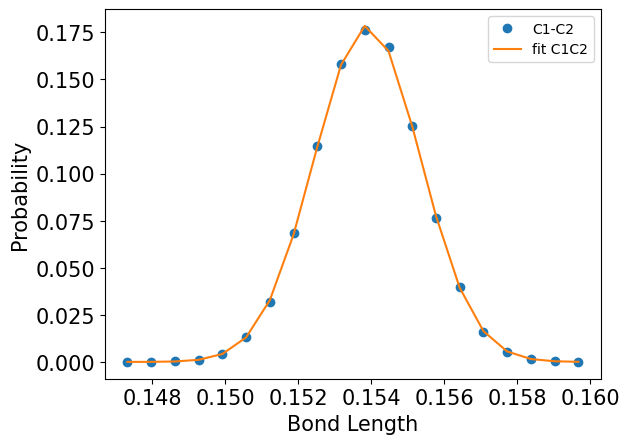

In [32]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

####SOLUTION####

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

### THIS IS WHAT YOU WANT TO TURN INTO A FUNCTION FOR HOMEWORK ####
counts, edges = np.histogram(C1C2bondlength, bins=20, range=[0.147,0.160])
centers = edges[:-1] + np.diff(edges)/2
density=counts/np.sum(counts)

###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

#C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,density)

plt.plot(centers, density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')


plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()


***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a: 0.17864857462953343 x0: 0.15389898435999452 fit_sigma: 0.0014523329398426032
a: 0.179104826242877 x0: 0.1539560549661584 fit_sigma: 0.0014479719302644266
a: 0.17941145299003466 x0: 0.15389920051828054 fit_sigma: 0.0014468292990451347


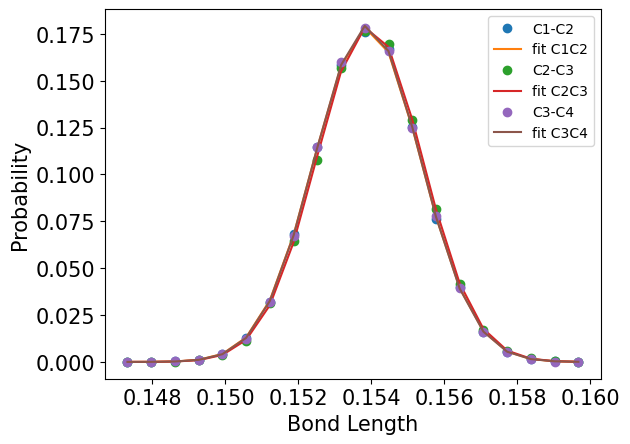

In [33]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####SOLUTION####

def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density)

C2C3_density,centers=histogram_bincenters(C2C3bondlength,0.147,0.160,20)
C2C3_fit,C2C3_fit_params=fit_gauss(centers,C2C3_density)

C3C4_density,centers=histogram_bincenters(C3C4bondlength,0.147,0.160,20)
C3C4_fit,C3C4_fit_params=fit_gauss(centers,C3C4_density)


plt.plot(centers, C1C2_density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')
plt.plot(centers, C2C3_density, 'o', label='C2-C3')
plt.plot(centers, C2C3_fit, '-', label='fit C2C3')
plt.plot(centers, C3C4_density, 'o', label='C3-C4')
plt.plot(centers, C3C4_fit, '-', label='fit C3C4')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()


**Homework Problem #2: convert these probability distributions to culmulative distribution functions**

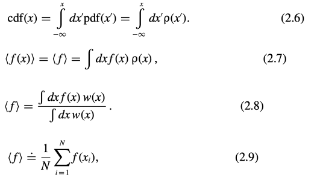

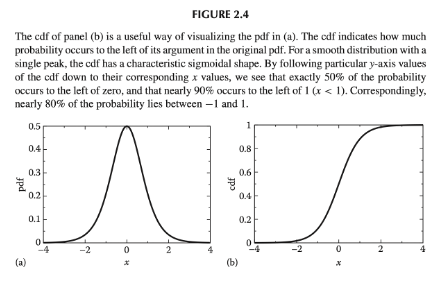

In [ ]:
#ADD CODE FOR CDFs HERE#

**Homework Problem #3: Lets draw some different some random frames from our trajectory (for example 10,100, and 1000),  calculate the probability distribution functions for 5 of these random samples, and fit  gaussians to these probability distirbution functions***
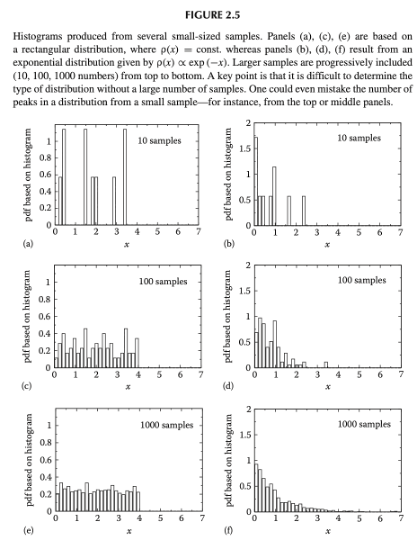

In [34]:
#ADD CODE FOR Random SAMPLES HERE#
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands


array([3798, 6970, 5425, 1831,  180, 4560, 5970, 3369, 3357, 5543])

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a good way to visualize the C-C-C-C dihedral angle 

(100000, 2)


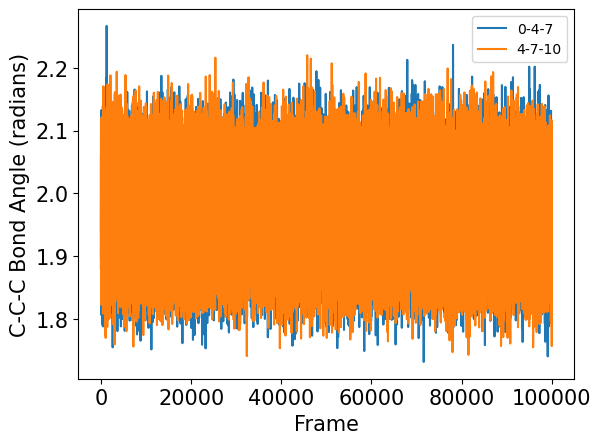

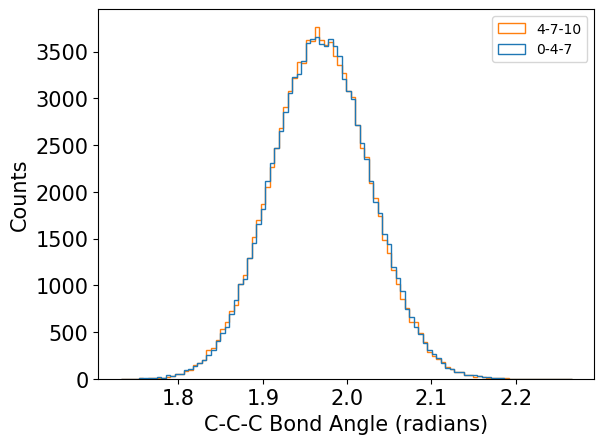

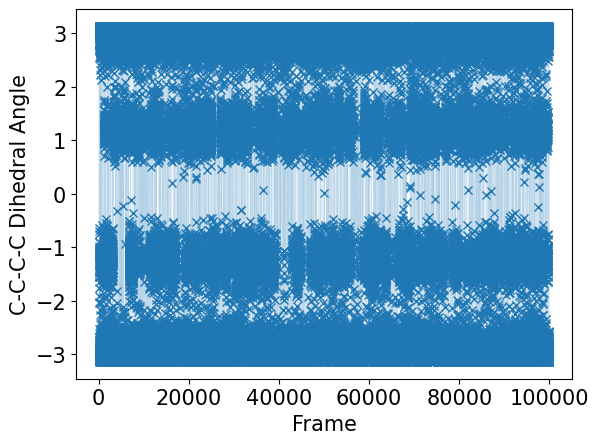

In [35]:
#Lets Compute Some Bond Angles 
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
#ang=np.degrees(angle_rad)
print(np.shape(ang))
plt.plot(ang,label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C Bond Angle (radians)', size=15)
plt.yticks(size=15)
plt.show()

plt.show()
plt.clf()
plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

#plt.plot(CCCC_torsion)
plt.plot(CCCC_torsion,marker='x',linewidth=.01)
#plt.xlim(0,2000)
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C-C Dihedral Angle', size=15)
plt.yticks(size=15)
plt.show()



***Homework Challenge Question:  Can you estimate the lifetime of the higher energy C-C-C-C dihedral states?*****

In [ ]:
####Challenge Question Can you estimate the lifetime of the higher energy C-C-C-C dihedral states####

**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

In [ ]:
#Are the bond angle and dihedral correlated?

ang1=ang[:,0]
ang2=ang[:,1]

plt.scatter(CCCC_torsion,ang1,marker='x',linewidth=0.04)
plt.scatter(CCCC_torsion,ang2,marker='x',linewidth=0.04)

r=np.corrcoef(CCCC_torsion[:,0], ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_torsion[:,0],ang1,1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCC_torsion[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print(line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('C-C-C-C Dihedral', size=18)
plt.ylabel('C-C-C Angle', size=18)
plt.title('Angle-Dihedral Correlation')

plt.show()


#plt.scatter(ang1[1:-1:10],ang2[1:-1:10])
#r=np.corrcoef(ang1, ang2)
#print("Angle Correlation r^2:",r[0,1])


**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

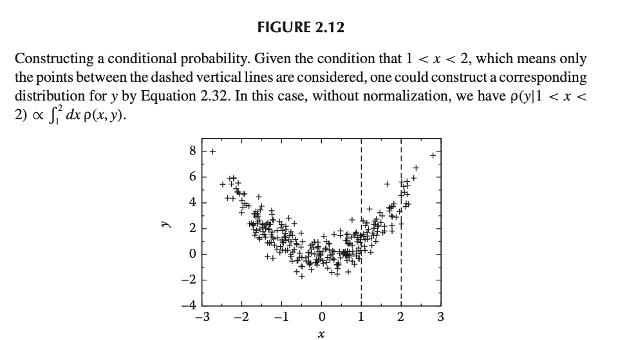

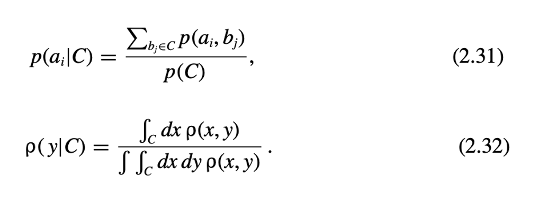

In [ ]:
#Homework problem 3##

In [ ]:
#print(ang1)
#print(ang1[1:])
#print(ang1[:-1])


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

In [ ]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

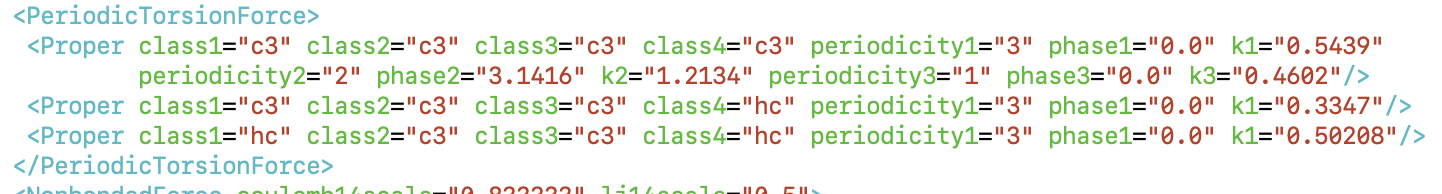

In [ ]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets right a function that takes paramters from the xml and writes the force field term

def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)


In [ ]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [ ]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  Why isn't it always the same?

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

In [ ]:
####Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]


#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]


In [ ]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
#diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]


In [ ]:
#COMPUTE THE TOTAL TORSION FORCE FIELD ENERGY PER FRAME


In [ ]:
#Compare the time course of CCCC torsion with its energy 
#Interpret what you are seeing in terms of conformations and energies


Plot The Total Torsion Energy As a Function of the C-C-C-C Dihedral Angle - Compare your plot Energetic Torsion Barriers from Cramer.  How Can you explain the Difference?

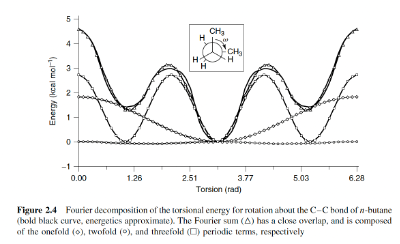

In [ ]:
#Solution


***Homework Problem #6: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [ ]:
###SOLUTION#####



***Homework Problem #7: Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [ ]:
#RUN NEW MD SIMULATION HERE#

**Homework Problem #8:  Calculate LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

**Challenge Problem:  Atempt to calculate all LJ interactions for a frame and all frames.  What does lj14scale mean?**


**Challenge Problem #2:  Attempt to calculate all Coulumb interactions for a frame and all frames**

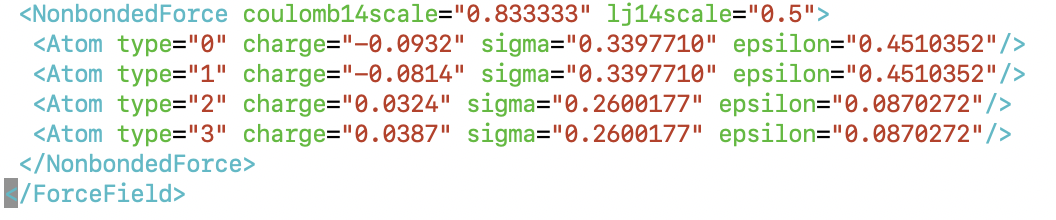




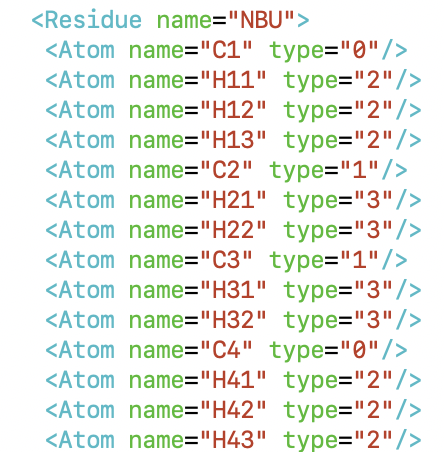

In [ ]:
#Calculate LJ and Couloumb Potentionals Here

In [ ]:
###SOLUTION###
#ONCE YOU HAVE FOUND SOME TORSION CORRECTIONS RUN A NEW SIMULATION 
#Make a new force field file 'butane.gaff2.cor1.xml'
